Reproduction of the paper "A Neural Probabilistic Language Model"

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# read in all the words
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [139]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mapping s to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}    
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [138]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append 
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [140]:
Xtr.shape, Xtr, Ytr.shape, Ytr

(torch.Size([182437, 3]),
 tensor([[ 0,  0,  0],
         [ 0,  0, 20],
         [ 0, 20,  1],
         ...,
         [25,  5, 14],
         [ 5, 14, 14],
         [14, 14,  1]]),
 torch.Size([182437]),
 tensor([20,  1, 21,  ..., 14,  1,  0]))

In [9]:
C = torch.randn((27,2))

In [10]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [11]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [12]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([228146, 100])

In [13]:
W2 = torch.randn((100, 27)) # 27个可能输出的字符
b2 = torch.randn(27)

In [14]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [19]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([228146, 27])

In [17]:
prob[0].sum()

tensor(1.0000)

In [35]:
loss = -prob[torch.arange(Y.shape[0]), Y].log().mean()
loss

tensor(19.5052)

In [26]:
# -------------------- # 

In [27]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [198]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [199]:
sum(p.nelement() for p in parameters)

11897

In [200]:
for p in parameters:
    p.requires_grad_()

In [201]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [202]:
lri = []
lossi = []
stepi = []

In [228]:
for i in range(30000):
    # mini-batch
    ix = torch.randint(0,Xtr.shape[0],(64,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (228146, 100)
    logits = h @ W2 + b2 # (228146, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad 
    
    # tracks stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

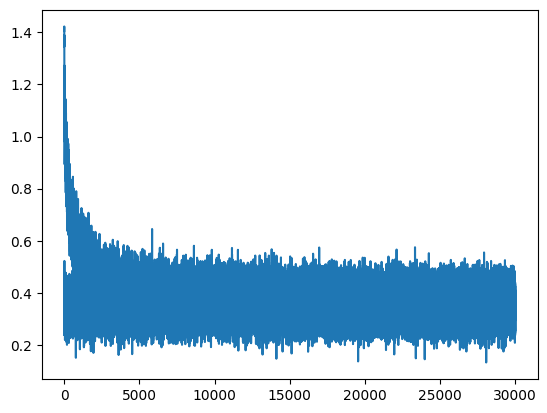

In [229]:
plt.plot(stepi, lossi)

In [230]:
emb = C[Xtr] # (228146, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (228146, 100)
logits = h @ W2 + b2 # (228146, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1730, grad_fn=<NllLossBackward0>)

In [231]:
emb = C[Xdev] # (228146, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (228146, 100)
logits = h @ W2 + b2 # (228146, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2156, grad_fn=<NllLossBackward0>)

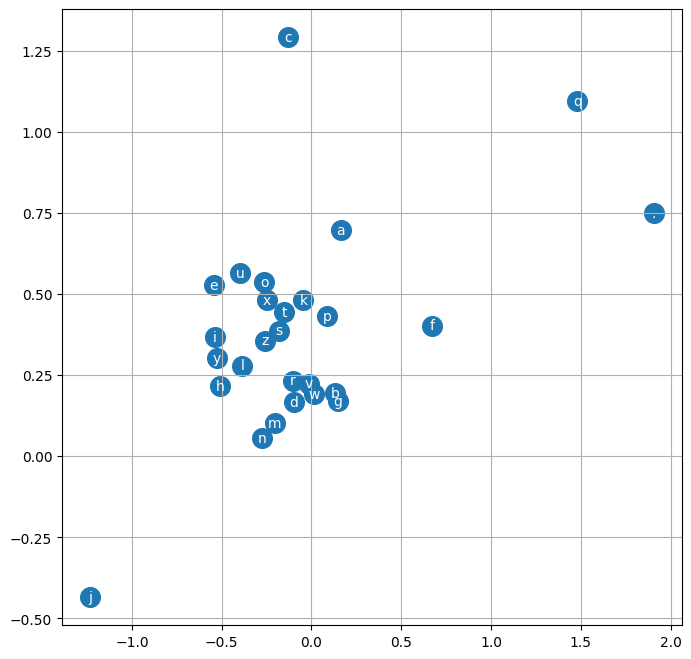

In [211]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [232]:
# sample from the model
block_size = 3

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, D)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmah.
amorie.
khy.
mri.
reviyah.
cassie.
rahnen.
delyah.
jareei.
ner.
kia.
chaiiv.
kaleig.
dham.
jorn.
quinn.
suline.
livabi.
wazelo.
dearynn.
